In [97]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# GRU + Meta data DAG model

Combining a GRU and a simple DNN on meta data into a single DAG


In [98]:
import numpy as np
import pandas as pd

import sys
sys.path.append('../')

from tqdm import tqdm
from config import interim_data_dir, raw_data_dir

from src.utils import read_shapefile

## Load Datasets

In [99]:
import numpy as np
import pandas as pd

from tqdm import tqdm
from config import interim_data_dir, raw_data_dir

from src.utils import read_shapefile

from config import processed_data_dir


# Sequential Data
dataset_version = 'v5.1'

train_features_df = pd.read_csv(processed_data_dir/'VI_datasets'/dataset_version/'train.csv', index_col=0)
test_features_df = pd.read_csv(processed_data_dir/'VI_datasets'/dataset_version/'test.csv', index_col=0)
class_weight = 1-train_features_df.y.value_counts(normalize=True)



# Meta data
metadata_version = 'v1'
train_meta_df = pd.read_csv(processed_data_dir / 'meta_data' / metadata_version / "train.csv")
test_meta_df = pd.read_csv(processed_data_dir / 'meta_data' / metadata_version / "test.csv")

## Process Data

### Sequential Data

In [100]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def impute_nan_inf(df):
    """
    Impute bad values (nan and inf) using
    the median of that feature on that time stamp
    for all farms
    
    TODO: This can be improved
    """
    
    # replace all nans variants with np.nan
    df = df.replace([np.nan, None, np.inf, -np.inf], np.nan)

    # replace all nans with the median value of all farms on that timestamp
    for ts, ts_df in df.groupby('time'):
        df.loc[ts_df.index] = ts_df.fillna(ts_df.median())
        
    return df


def transform_dataset(features_df):
    """
    Create a data array in the shape (n_ids, n_time, n_features)
    
    If it is the training set, also return dictionary mapping index
    in dataset to correct label.
    
    """
    
    n_ids = features_df.farm_id.nunique()

    feature_cols = [col for col in features_df.columns if col not in ['farm_id','y','time']]
    
    n_features = len(feature_cols)

    data = np.ndarray((n_ids, 11, n_features))
    
    classes = {}
    for i, (farm_id, farm_df) in enumerate(features_df.groupby(['farm_id'])):

        data[i,:,:] = farm_df[feature_cols].values
        
        if 'y' in features_df.columns:
            c = farm_df['y'].unique()
            classes[i] = c[0]
            
    return data, classes
    

        
train_features_df = impute_nan_inf(train_features_df)
test_features_df = impute_nan_inf(test_features_df)


# Make copies to compare before / after normalization
train_copy = train_features_df.copy()
test_copy = test_features_df.copy()

times = train_features_df['time'].unique()
feature_cols = [col for col in test_features_df.columns if col not in ['farm_id','time']]

for ts in times:
    scaler = StandardScaler()
    
    train_ts_df = train_copy[train_copy.time == ts]
    test_ts_df = test_copy[test_copy.time == ts]
    
    train_features_df.loc[train_ts_df.index, feature_cols] = scaler.fit_transform(train_ts_df[feature_cols])
    test_features_df.loc[test_ts_df.index, feature_cols] = scaler.transform(test_ts_df[feature_cols])
    
    
train_data, train_labels_dict = transform_dataset(train_features_df)
test_data, _ = transform_dataset(test_features_df)

print('Sequential Datasets:')
print('Train data:\t\t',train_data.shape)
print('Test data:\t\t',test_data.shape)

Sequential Datasets:
Train data:		 (2494, 11, 110)
Test data:		 (1074, 11, 110)


### Meta Data

In [90]:
from sklearn.preprocessing import OneHotEncoder

# Select relevant fields
train_meta_df = train_meta_df[['Field_Id','Area','Subregion']]
test_meta_df = test_meta_df[['Field_Id','Area','Subregion']]

# Scale Area 
scaler = StandardScaler()
train_meta_df.loc[train_meta_df.index, ['Area']] = scaler.fit_transform(train_meta_df[['Area']])
test_meta_df.loc[test_meta_df.index, ['Area']] = scaler.transform(test_meta_df[['Area']])

# Convert subregion to one-hot encoding
encoder = OneHotEncoder(sparse=False)

train_ohe = encoder.fit_transform(train_meta_df[['Subregion']])
test_ohe = encoder.transform(test_meta_df[['Subregion']])

# Stack scaled 
train_meta_data = np.hstack((train_meta_df[['Area']].values, train_ohe))
test_meta_data = np.hstack((test_meta_df[['Area']].values, test_ohe)) 

print('Meta Data Shape: ')
print('Train:\t',train_meta_data.shape)
print('Test:\t',test_meta_data.shape)

Meta Data Shape: 
Train:	 (2494, 9)
Test:	 (2494, 9)


## Start Modelling Process

### Create validation set

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

seed = 420

# Copy for later
data = train_data.copy()

train_labels = list(train_labels_dict.values())
train_indexes = list(train_labels_dict.keys())
train_idx, val_idx, train_labels, val_labels = train_test_split(train_indexes, train_labels, stratify=train_labels, test_size=0.2, random_state=seed)

le = LabelEncoder()
train_labels_enc = le.fit_transform(np.array(train_labels).reshape(-1,1))
val_labels_enc = le.transform(np.array(val_labels).reshape(-1,1))

train_data = data[train_idx,:, :]
val_data = data[val_idx,:, :]

# Split Meta data into train and val
train_data_meta = train_meta_data[train_idx,:]
val_data_meta = train_meta_data[val_idx,:]


print('Split Dataset Shapes:')
print('train data:\t Seq: {}\t Meta: {}'.format(train_data.shape, train_data_meta.shape))
print('train data:\t Seq: {}\t Meta: {}'.format(val_data.shape, val_data_meta.shape))

Split Dataset Shapes:
train data:	 Seq: (1995, 11, 110)	 Meta: (1995, 9)
train data:	 Seq: (499, 11, 110)	 Meta: (499, 9)


### Create model

In [94]:
import tensorflow as tf
import keras
from keras import models, layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from src.visualization.tf_viz import PlotLosses

from keras.layers import Input, Dense
from keras.models import Model

def get_dag_model(n_ts_features, n_meta_features):
    
    # Get the model
    GRU_cells = 16
    recurrent_activation = 'hard_sigmoid'
    recurrent_dropout = 0.6093571771811351


    # Temporal Model
    input_timeseries = Input(shape=(11,n_ts_features,))

    x = layers.Dense(8, activation='relu')(input_timeseries)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.GRU(GRU_cells, 
                         return_sequences=True,
                         recurrent_activation=recurrent_activation, 
                         recurrent_dropout=recurrent_dropout)(x)
    x = layers.GRU(GRU_cells, 
                         return_sequences=True,
                         recurrent_activation=recurrent_activation, 
                         recurrent_dropout=recurrent_dropout)(x)
    x = layers.Flatten()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    
    # Meta Model
    input_meta_data = Input(shape=(n_meta_features,))

    y = layers.Dense(n_meta_features, activation='relu',)(input_meta_data)
    y = layers.Dropout(0.3)(y)
    y = layers.BatchNormalization()(y)
    y = layers.Dense(int(n_meta_features*2), activation='relu')(y)
    y = layers.Dropout(0.3)(y)
    y = layers.BatchNormalization()(y)

    bottleneck = layers.concatenate([x,y])
    bottleneck = layers.Dense(9, activation='softmax')(bottleneck)

    model = Model(inputs=[input_timeseries,input_meta_data], outputs=bottleneck)
    
    return model

### Set modelling parameters

In [95]:
from src.models.clr_callback import CyclicLR
from keras.callbacks import ModelCheckpoint

from config import models_dir

checkpoint_filename = 'meta_gru_and_meta_val.hdf5'

lr = 3e-4

# Choose optimizer
optimizer = keras.optimizers.RMSprop(lr)

# Define callbacks
checkpoint = ModelCheckpoint(
    str(models_dir / checkpoint_filename), 
    save_best_only=True, 
    mode='min', 
    monitor='val_loss'
)
plot_losses = PlotLosses()
es = EarlyStopping(monitor='val_loss', verbose=1, patience=100)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=50, verbose=1, factor=0.5, min_delta=0.001,)


# Combine Callbacks
callbacks = [
    plot_losses, 
    es, 
    reduce_lr
]

# Create model & compile
model = get_dag_model(train_data.shape[-1], train_data_meta.shape[-1])

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy')

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 11, 110)      0                                            
__________________________________________________________________________________________________
dense_54 (Dense)                (None, 11, 8)        888         input_18[0][0]                   
__________________________________________________________________________________________________
batch_normalization_53 (BatchNo (None, 11, 8)        32          dense_54[0][0]                   
__________________________________________________________________________________________________
dropout_53 (Dropout)            (None, 11, 8)        0           batch_normalization_53[0][0]     
__________________________________________________________________________________________________
dense_55 (

## TRAIN!!

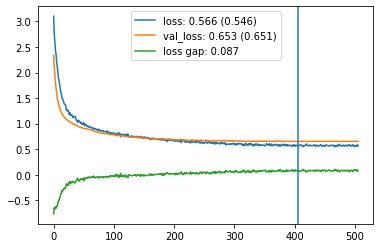

Epoch 00506: early stopping


In [96]:
batch_size = 128

model.fit([train_data, train_data_meta], 
          train_labels_enc,
          batch_size=batch_size,
          validation_data=([val_data, val_data_meta], val_labels_enc), 
          class_weight=class_weight,
          verbose=0,
          epochs=epoch_size, 
          callbacks=callbacks)

### Now on all data

In [54]:
all_data = np.vstack([train_data, val_data])
all_labels = np.array(list(train_labels_enc) + list(val_labels_enc))

all_data_meta = np.vstack([train_data_meta, val_data_meta])

class_weight = (1 - pd.Series(all_labels).value_counts(normalize=True)).to_dict()

In [58]:
from src.models.clr_callback import CyclicLR
from keras.callbacks import ModelCheckpoint

from config import models_dir

from keras.layers import Input, Dense
from keras.models import Model

lr = 3e-4


# Choose optimizer
optimizer = keras.optimizers.RMSprop(lr)
checkpoint = ModelCheckpoint(str(models_dir / 'gru_dag_5.1.hdf5'), save_best_only=True, mode='min', monitor='loss')

callbacks = [
    plot_losses, 
    checkpoint
]

model = get_dag_model(all_data.shape[-1], all_data_meta.shape[-1])

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy')

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 11, 110)      0                                            
__________________________________________________________________________________________________
dense_42 (Dense)                (None, 11, 8)        888         input_14[0][0]                   
__________________________________________________________________________________________________
batch_normalization_41 (BatchNo (None, 11, 8)        32          dense_42[0][0]                   
__________________________________________________________________________________________________
input_15 (InputLayer)           (None, 9)            0                                            
__________________________________________________________________________________________________
dropout_41

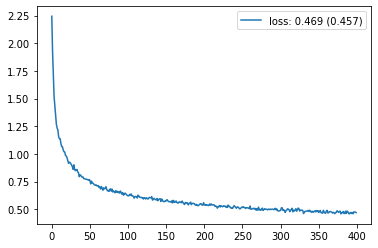

In [59]:
model.fit([all_data,all_data_meta], 
          all_labels,
          batch_size=64,
          class_weight=class_weight,
          verbose=0,
          epochs=400, 
          callbacks=callbacks)

### Load Best Model

In [61]:
from keras.models import load_model

model = load_model(str(models_dir / 'gru_dag_5.1.hdf5'))

## Make a submission

In [62]:
def make_sub(predictions, ids_list):
    
    sub_df = pd.read_csv(raw_data_dir / 'sample_submission_fixed.csv')

    new_sub = sub_df.copy().set_index('field_id')

    new_sub.loc[ids_list] = predictions
    
    return new_sub

predictions = model.predict([test_data, test_meta_tensor])
test_ids = sorted(list(test_features_df.farm_id.unique()))
sub_df = make_sub(predictions, test_ids)
sub_df.head()

,crop_id_1,crop_id_2,crop_id_3,crop_id_4,crop_id_5,crop_id_6,crop_id_7,crop_id_8,crop_id_9
field_id,,,,,,,,,
5,0.000023,0.000004,0.000179,0.000051,1.268734e-05,0.009390,0.000053,0.818929,0.171359
6,0.000008,0.000011,0.000192,0.000101,2.019262e-05,0.011320,0.000106,0.802623,0.185619
10,0.000020,0.000006,0.000918,0.000289,9.941327e-07,0.001170,0.000172,0.927542,0.069882
18,0.000008,0.000003,0.000061,0.000007,4.946623e-07,0.000396,0.000046,0.863625,0.135854
23,0.000039,0.001674,0.001167,0.000023,5.607085e-07,0.000920,0.000256,0.756158,0.239763


### Save submission file

In [63]:
from config import subs_dir

fname = 'gru_dag_data_v5.1'
sub_df.to_csv(subs_dir / f'{fname}.csv')

### Save model architecture

In [64]:
with open(subs_dir / 'architectures' / f'{fname}.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))